In [1]:
library(tidyverse)
library(magrittr)
library(ggrepel)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.2.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract



In [2]:
read_tsv('../results/gwas/t1d/EGAD00000000008_prediction.tsv', col_types = 'ciid') %>%
    mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
           model = gsub('-B=0', '', model),
           model = gsub('-B=', ', B = ', model),
           model = gsub('-M=3', '', model),
           model = gsub(', discrete_x = True', '', model)) %>%
    group_by(model) %>%
    summarize(n = n(), ended = sum(!is.na(accuracy)),
              sem = sd(accuracy, na.rm = T) / sqrt(ended), accuracy = mean(accuracy, na.rm = T) ) %>%
    ungroup


model,n,ended,sem,accuracy
"HSIC Lasso, B = 10",10,7,0.0014742568,0.9930711
"HSIC Lasso, B = 5",10,10,0.0008290821,0.9937233
LARS,10,10,0.0011100920,0.9964337
mRMR,10,10,0.0010853744,0.9961484
Raw,5,5,0.0050516209,0.9697575


In [3]:
map <- read_tsv('../results/gwas/t1d/EGAD00000000008.map',
                      col_names = F, col_types = 'icii') %>%
    set_colnames(c('chr', 'snp', 'cm', 'pos')) %>%
    select(-cm)

gwas <- read_tsv('../results/gwas/t1d/univariate_association.tsv', col_types = 'iccccccd') %>%
    rename(chr = CHR, snp = SNP) %>%
    inner_join(map, by = c('chr', 'snp'))

hl_snps <- read_tsv('../results/gwas/t1d/EGAD00000000008_hsic_lasso_C=50_SELECT=50_M=3_B=5.txt', 
                 col_names = F, col_types = 'c') %>%
    set_colnames('snp') %>%
    .$snp

Warning message:
“1 parsing failure.
   row col   expected    actual                                      file
500568  X1 an integer NT_113884 '../results/gwas/t1d/EGAD00000000008.map'
”Warning message:
“5 parsing failures.
    row col   expected    actual                                             file
2502836 CHR an integer NT_113884 '../results/gwas/t1d/univariate_association.tsv'
2502837 CHR an integer NT_113884 '../results/gwas/t1d/univariate_association.tsv'
2502838 CHR an integer NT_113884 '../results/gwas/t1d/univariate_association.tsv'
2502839 CHR an integer NT_113884 '../results/gwas/t1d/univariate_association.tsv'
2502840 CHR an integer NT_113884 '../results/gwas/t1d/univariate_association.tsv'
”

In [4]:
manhattan <- function(gwas, selected, map, test = 'GENO') {
    
    snp2gene <- read_tsv('../results/gwas/snp2hgnc.tsv', 
                     col_types = 'cc')
    
    gwas <- gwas %>%
        filter(TEST == test) %>%
        mutate(selected = ifelse(snp %in% selected, 'Yes', 'No')) %>%
        arrange(selected)

    don <- gwas %>% 

      # Compute chromosome size
      group_by(chr) %>% 
      summarise(chr_len=max(pos)) %>% 

      # Calculate cumulative position of each chromosome
      mutate(tot=cumsum(chr_len)-chr_len) %>%
      select(-chr_len) %>%

      # Add this info to the initial dataset
      left_join(gwas, ., by='chr') %>%

      # Add a cumulative position of each SNP
      arrange(chr, pos) %>%
      mutate( BPcum=pos+tot) %>%
      left_join(arrange(snp2gene, symbol) %>% group_by(snp) %>% summarize(symbol = head(symbol, 1)), by = 'snp')

    axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

    ggplot(don, aes(x=BPcum, y=-log10(P))) +

        # Show all points
        geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
        geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(P)), color = 'black') +
        geom_text_repel(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(P), label = symbol)) +
        scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

        # Add Bonferroni line
        geom_hline(yintercept = -log10(.05/500000), color = 'red') +

        # custom X axis:
        scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
        scale_y_continuous(expand = c(0, 0) ) +     # remove space between plot area and x axis

        # Custom the theme:
        theme_bw() +
        theme( 
          legend.position="none",
          panel.border = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank()
        ) +
        labs(x = 'Chromosome')
    
}

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 24 rows containing missing values (geom_text_repel).”

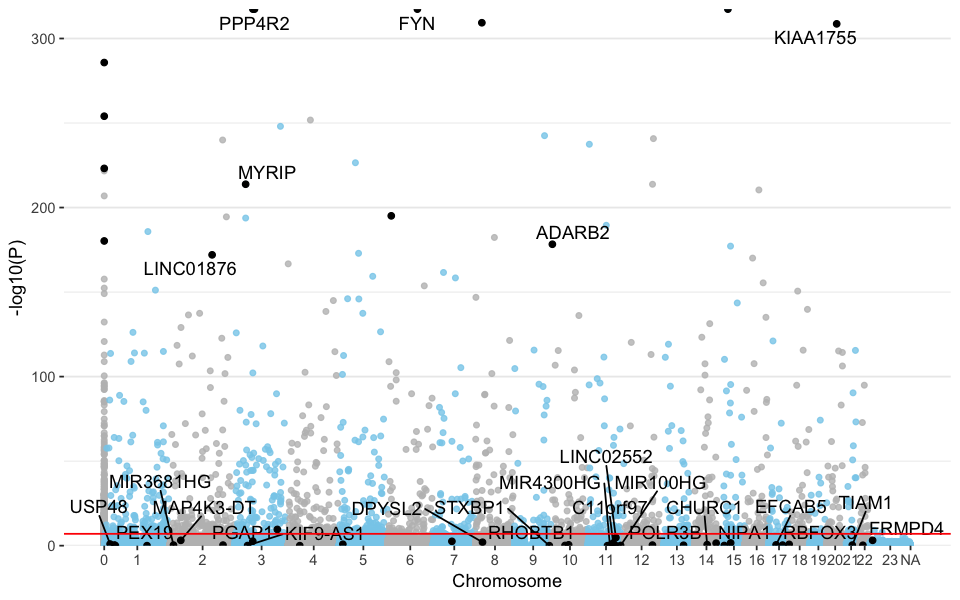

In [5]:
options(repr.plot.width=8, repr.plot.height=5)
manhattan(gwas, hl_snps, map)